In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np


In [ ]:
# 1. Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [ ]:
# 2. Define sparsity regularizer
from tensorflow.keras import backend as K

def kl_divergence(rho, rho_hat):
    """KL divergence sparsity penalty"""
    return rho * K.log(rho / (rho_hat + 1e-10)) + (1 - rho) * K.log((1 - rho) / (1 - rho_hat + 1e-10))

class SparseActivityRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, rho=0.05, beta=1.0):
        self.rho = rho  # desired sparsity
        self.beta = beta  # weight of penalty

    def __call__(self, x):
        rho_hat = K.mean(x, axis=0)  # average activation of hidden units
        return self.beta * K.sum(kl_divergence(self.rho, rho_hat))



In [ ]:
# 3. Build sparse autoencoder
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Flatten()(input_img)
encoded = layers.Dense(64, activation="sigmoid",
                       activity_regularizer=SparseActivityRegularizer(rho=0.05, beta=5.0))(x)

# Decoder
decoded = layers.Dense(28*28, activation="sigmoid")(encoded)
decoded = layers.Reshape((28, 28, 1))(decoded)

# Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# 4. Train
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# 5. Reconstruct examples


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 27.0631 - val_loss: 1.2128
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.5316 - val_loss: 1.1425
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4564 - val_loss: 1.0982
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4111 - val_loss: 1.0345
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3720 - val_loss: 1.0214
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3503 - val_loss: 1.0071
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3342 - val_loss: 0.9639
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3212 - val_loss: 0.9675
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.3109 - val_loss: 0.9764
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3008 - val_loss: 0.9277


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


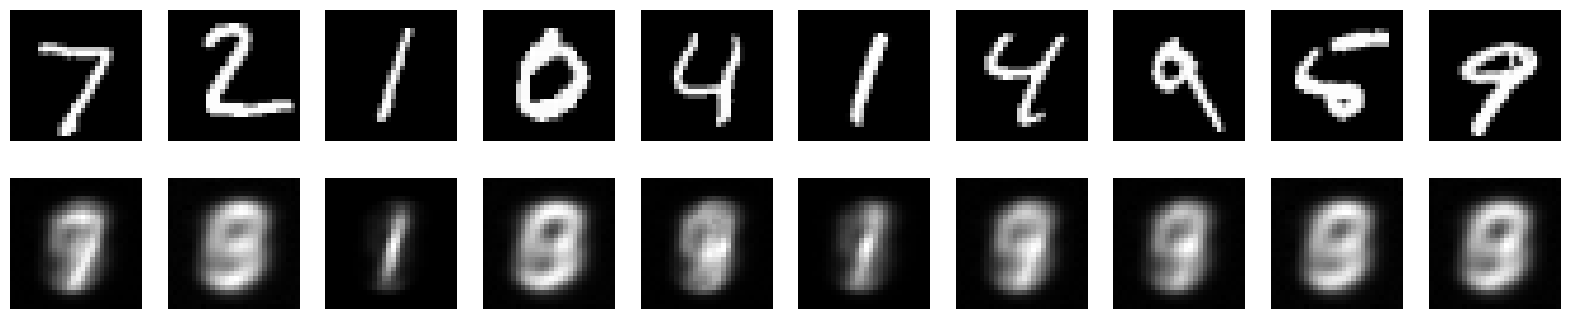

In [ ]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test[:10])

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

 #Reconstructed
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()
